# <center>Audio Emotion Recognition</center>
## <center>Part 6 - 2D CNN implementation - 66% accuracy </center>
#### <center> 12th September 2019 </center> 
#####  <center> Eu Jin Lok </center> 

# Introduction 
We arrive to our advance implementation part of the speaker emotion classifier series. We're going to build a more advance modelling approach, and with confidence, I should see a drastic improvement of the accuracy of the emotion classifier.

The combination of the implementation above should not only improve our out-of-fold accuracy, but also ensure better generalisation to new dataset. However, whether it is practical enough for deployment or not, is a different story all together...

But the show has to carry on, so lets begin, the agenda below:
1. [Custom functions](#custom)
2. [MFCC without augmentation](#MFCConly) 
3. [MFCC with Augmentation](#MFCCaug)
4. [Log-melspectogram without augmentation](#logmelonly)
5. [Log-melspectogram with augmentation ](#logmelaug)
6. [Final thoughts](#final)

-------------------------------------
If you've followed my kernels and post this far, then I thank you for your audience and attention. But like the old saying, "standing on the shoulders of giants", I am only able to get this far because I've learnt from others. So before continuing on, I wanted to take the time here to say thanks to the following individuals who've taken the time to write these amazing notebooks, so that you and I can expedite our learning process. So they are:  

- [Zafarullah](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data)

When I first started out on learning about audio, Zafar's kernel here was the real launch pad for me. So thank you. Furthermore, alot of the CNN code I've implemented here are based on Zafar's original kernels [here](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data)

- [Mitesh Puthran](https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer)

The building of the audio emotion recognition series is inspired by this [repository](https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer). I initially started out as a small experiment out of curiosity. And then it grew to become a multi-series kernel post in itself as I got deeper into the experiements. After this series is completed, I'm going to contribute back to Mitest's original github repo. Thank you Mitesh

- [Reza Chu](https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3)

The data augmentation idea was brought about from this blogpost. The author also leveraged on Mitesh's code repository and build up on it like I did. But Reza really injected a whole new area of knowledge that I didn't know about. We're all famiiar with data augmentation methods on images, who would have thought (or maybe just me) that audio is no different! So go check out Reza's [post](https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3)

-------------------------------------

And finally, I want to thank the 4 authors for their excellent dataset, without it, writing this notebook could not have been possible. The original source of the dataset links are below:

- [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
- [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)
- [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/Database.html)
- [RAVDESS](https://zenodo.org/record/1188976#.XYP8CSgzaUk)
- [RAVDESS_Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)


In [16]:
# # Keras
# import keras
# from keras import regularizers
# from keras.preprocessing import sequence
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential, Model, model_from_json
# from keras.layers import Dense, Embedding, LSTM
# from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
# from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
# from keras.utils import np_utils, to_categorical
# from keras.callbacks import (EarlyStopping, LearningRateScheduler,
#                              ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
# from keras import losses, models, optimizers
# from keras.activations import relu, softmax
# from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
#                           GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)
# 
# # sklearn
# from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# 
# # Other  
# from tqdm import tqdm, tqdm_pandas
# import scipy
# from scipy.stats import skew
# import librosa
# import librosa.display
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from matplotlib.pyplot import specgram
# import pandas as pd
# import seaborn as sns
# import glob 
# import os
# import sys
# import IPython.display as ipd  # To play sound in the notebook
# import warnings
# # ignore warnings 
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")

In [17]:
# Keras
import keras
from keras import regularizers
from keras_preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras import Sequential, Model
from keras._tf_keras.keras.models import model_from_json
from keras._tf_keras.keras.layers import Dense, Embedding, LSTM, Input, Flatten, Dropout, Activation, \
    BatchNormalization, Conv2D, MaxPooling1D, AveragePooling1D
from keras._tf_keras.keras.utils import to_categorical
from keras._tf_keras.keras.callbacks import ModelCheckpoint
from keras._tf_keras.keras import utils
from keras._tf_keras.keras import optimizers
import np_utils

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other
import librosa
from librosa import feature
import json
from scipy.io import wavfile
# from python_speech_features import mfcc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
from tqdm import tqdm
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

import sys
import warnings

## 1. Custom functions 
So we'll be building some custom functions to extract various features. If you've been following my series from the start, you'd be familiar with what these functions are doing. With the exception of the 2D CNN model which is new here. Further explanations ahead. 

The 2D CNN takes in a 2D array of 30 MFCC bands by 216 audio length as input data. so just imagine it as a 30 x 216 pixel image. And just like in images, we could inlude a 3rd Dimension, but that's a topic for another time. It's got 4 convolution blocks of batch normalisation, max pooling and a dropout node. So your standard setup similar to VGG19, just not as deep. And we're using Adam for our optimiser. 

For printing our results, i've created a class instead to encapsulate the various attributes. So that way I don't have to repeat the same code many times. 

In [42]:
from keras.src.activations import softmax
from keras._tf_keras.keras import models, losses
from keras._tf_keras.keras.layers import Convolution2D, MaxPool2D

'''
1. Data Augmentation method   
'''
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

'''
2. Extracting the MFCC feature as an image (Matrix format).  
'''
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(y=data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X


'''
3. Confusion matrix plot 
'''        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
'''
# 4. Create the 2D CNN model 
'''
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 14
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

'''
# 5. Other functions 
'''
class get_results:
    '''
    We're going to create a class (blueprint template) for generating the results based on the various model approaches. 
    So instead of repeating the functions each time, we assign the results into on object with its associated variables 
    depending on each combination:
        1) MFCC with no augmentation  
        2) MFCC with augmentation 
        3) Logmelspec with no augmentation 
        4) Logmelspec with augmentation
    '''
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)
    
    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_angry':'female'
               , 'female_disgust':'female'
               , 'female_fear':'female'
               , 'female_happy':'female'
               , 'female_sad':'female'
               , 'female_surprise':'female'
               , 'female_neutral':'female'
               , 'male_angry':'male'
               , 'male_fear':'male'
               , 'male_happy':'male'
               , 'male_sad':'male'
               , 'male_surprise':'male'
               , 'male_neutral':'male'
               , 'male_disgust':'male'
              })

        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

In previous post you've seen the visualisation of the MFCC, where it captures all the core information of the audio file into a single image. Well, if an audio information can be interpreted as an image, then surely we can apply the same image recognition approaches like VGG19 or RESNET and the like? 

The answer is yes. And is suprisingly very fast and accurate. Its not as accurate as when applying RNN type models on the audio wave itself. But its very close to its accuracy potential, and heaps faster. There's some assumptions and limitations depending on use cases of course. 

Lets pick up the meta-data file again that has all our file path

In [19]:
ref = pd.read_csv(r"C:\Users\eo19181\Documents\All -  Datasets\data_paths.csv")
ref.head()

,labels,source,path
0,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...
1,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...
2,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...
3,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...
4,female_angry,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...


<a id="MFCConly"></a>
## 2. MFCC without augmentation
So, what I'm about to do is use the entire MFCC data and treat it as an image, and push it through to a 2D CNN instead of a 1D CNN that we saw in previous parts. This will be without data augmentation for now. The convergence is very quick so instead of letting it run over 50 or more epochs, I'm going to just cut it at 20. 

In [20]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n_mfcc, 0, 1)

100%|██████████| 29662/29662 [08:17<00:00, 59.64it/s] 


In [22]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))


# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)


X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Epoch 1/20
1391/1391 - 55s - 40ms/step - acc: 0.3286 - loss: 1.9722 - val_acc: 0.4640 - val_loss: 1.5218
Epoch 2/20
1391/1391 - 51s - 37ms/step - acc: 0.5299 - loss: 1.3502 - val_acc: 0.5964 - val_loss: 1.1350
Epoch 3/20
1391/1391 - 51s - 37ms/step - acc: 0.5955 - loss: 1.1525 - val_acc: 0.5655 - val_loss: 1.1636
Epoch 4/20
1391/1391 - 55s - 39ms/step - acc: 0.6295 - loss: 1.0486 - val_acc: 0.6878 - val_loss: 0.8792
Epoch 5/20
1391/1391 - 51s - 37ms/step - acc: 0.6543 - loss: 0.9760 - val_acc: 0.6916 - val_loss: 0.8464
Epoch 6/20
1391/1391 - 89s - 64ms/step - acc: 0.6708 - loss: 0.9297 - val_acc: 0.6749 - val_loss: 0.8979
Epoch 7/20
1391/1391 - 64s - 46ms/step - acc: 0.6829 - loss: 0.8942 - val_acc: 0.7170 - val_loss: 0.7698
Epoch 8/20
1391/1391 - 56s - 40ms/step - acc: 0.6964 - loss: 0.8567 - val_acc: 0.7356 - val_loss: 0.7263
Epoch 9/20
1391/1391 - 54s - 39ms/step - acc: 0.7043 - loss: 0.8303 - val_acc: 0.7106 - val_loss: 0.8000
Epoch 10/20
1391/1391 - 54s - 39ms/step - acc: 0.7145 -

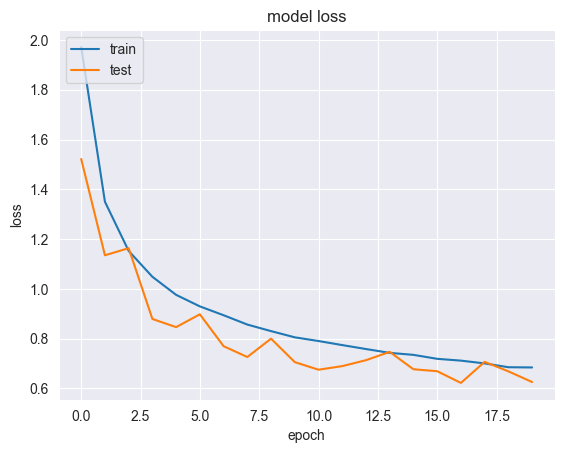

compile_metrics: 77.25%
464/464 - 4s - 8ms/step


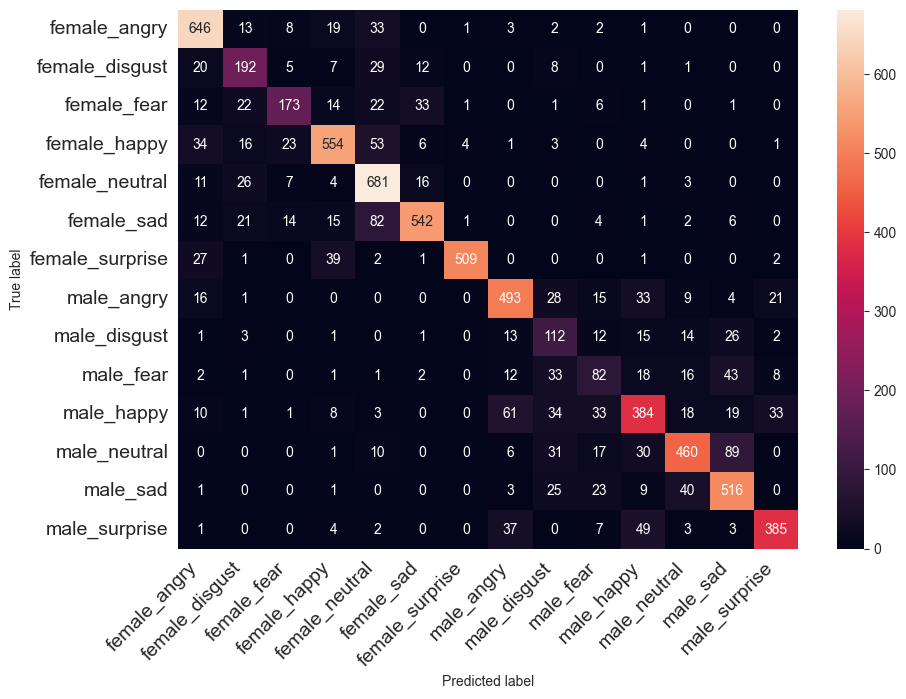

In [24]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

<a id="MFCCaug"></a>
## 3. MFCC with Augmentation 
Great result with using MFCC and applying a 2D CNN on it! __64% overall accuracy__, that's a huge leap from the 48% that we saw in [Part 5](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation). 

Now lets see what happens when we add in the extra step of data augmentation....

In [27]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc_aug = prepare_data(ref, n_mfcc, aug = 1, mfcc = 1)

100%|██████████| 29662/29662 [08:45<00:00, 56.46it/s] 


In [28]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc_aug
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)

# X_train = (X_train - mean)/std
# X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Epoch 1/20
1391/1391 - 56s - 40ms/step - acc: 0.2720 - loss: 2.1264 - val_acc: 0.4504 - val_loss: 1.5872
Epoch 2/20
1391/1391 - 59s - 42ms/step - acc: 0.4451 - loss: 1.5725 - val_acc: 0.5589 - val_loss: 1.2577
Epoch 3/20
1391/1391 - 60s - 43ms/step - acc: 0.5207 - loss: 1.3611 - val_acc: 0.5289 - val_loss: 1.3015
Epoch 4/20
1391/1391 - 60s - 43ms/step - acc: 0.5663 - loss: 1.2324 - val_acc: 0.5833 - val_loss: 1.1609
Epoch 5/20
1391/1391 - 59s - 43ms/step - acc: 0.5959 - loss: 1.1513 - val_acc: 0.6624 - val_loss: 0.9490
Epoch 6/20
1391/1391 - 59s - 42ms/step - acc: 0.6159 - loss: 1.0852 - val_acc: 0.6377 - val_loss: 1.0086
Epoch 7/20
1391/1391 - 60s - 43ms/step - acc: 0.6310 - loss: 1.0398 - val_acc: 0.6529 - val_loss: 0.9542
Epoch 8/20
1391/1391 - 60s - 43ms/step - acc: 0.6434 - loss: 1.0100 - val_acc: 0.6816 - val_loss: 0.9007
Epoch 9/20
1391/1391 - 68s - 49ms/step - acc: 0.6581 - loss: 0.9672 - val_acc: 0.6920 - val_loss: 0.8266
Epoch 10/20
1391/1391 - 56s - 40ms/step - acc: 0.6654 -

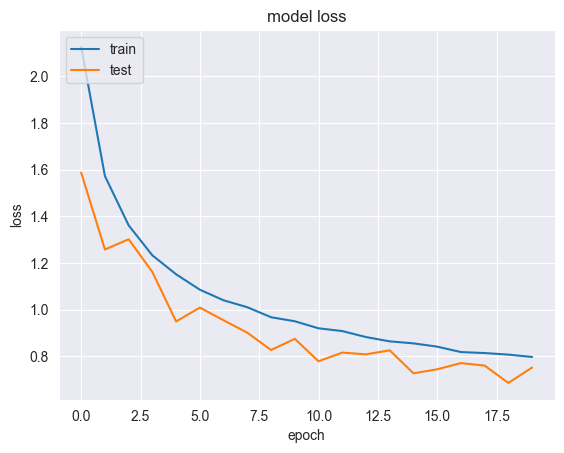

compile_metrics: 73.15%
464/464 - 4s - 8ms/step


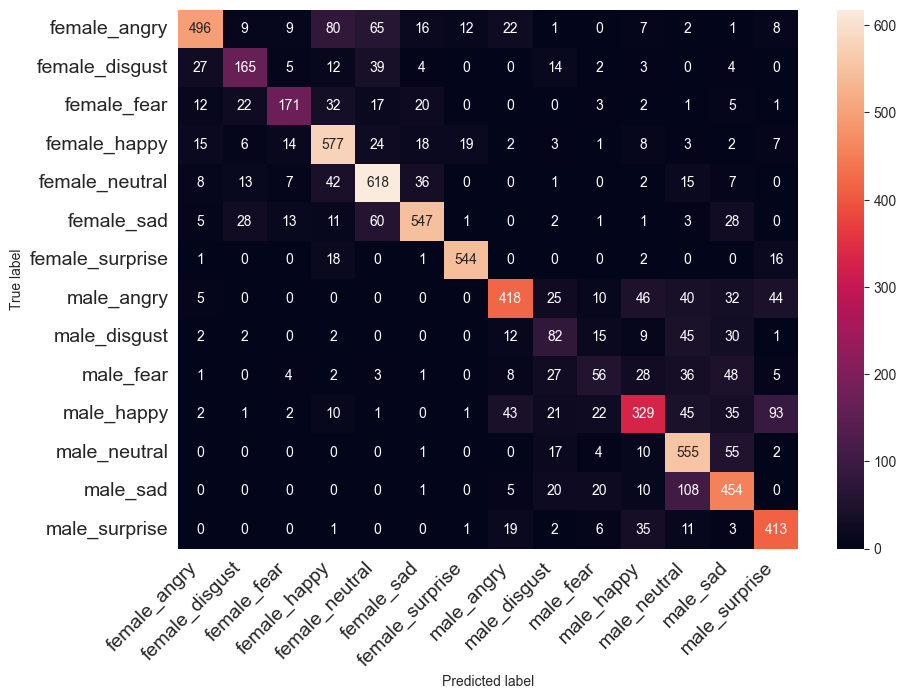

In [29]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

<a id="logmelonly"></a>
## 4. Log-melspectogram without augmentation
The accuracy is 60%, a slight drop from 64% without augmentation which is interesting and slightly unexpected. The plot of the logloss also indicates that it's converged. Suppose augmentation doesn't really do much for MFCC here... Note that due to some weird behaviour with the standardisation, I had to turn it off. So maybe that has some minor impact on the accuracy drop. 

Now, we're going to look at another type of feature call log-melspectogram. I've not covered it in this series but you can check out another kernel where I covered this feature quite extensively, right [here](https://www.kaggle.com/ejlok1/part-2-extracting-audio-features). But in short, if we treat the log-melspectogram like an image just like we did with the MFCC, then we can feed it into the same 2D CNN architecture that we built! Lets give it a try, without augmentation first...

In [43]:
# sampling_rate=44100
# audio_duration=2.5
n_melspec = 60
# df, n, aug, mfcc
specgram = prepare_data(df=ref, n=n_melspec, aug=0, mfcc=0)################

100%|██████████| 29662/29662 [08:03<00:00, 61.39it/s] 


In [44]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Epoch 1/20
1391/1391 - 113s - 81ms/step - acc: 0.2437 - loss: 2.2060 - val_acc: 0.3658 - val_loss: 1.8336
Epoch 2/20
1391/1391 - 110s - 79ms/step - acc: 0.3816 - loss: 1.7992 - val_acc: 0.4902 - val_loss: 1.4973
Epoch 3/20
1391/1391 - 109s - 79ms/step - acc: 0.4641 - loss: 1.5368 - val_acc: 0.5897 - val_loss: 1.2229
Epoch 4/20
1391/1391 - 110s - 79ms/step - acc: 0.5189 - loss: 1.3788 - val_acc: 0.5696 - val_loss: 1.2067
Epoch 5/20
1391/1391 - 110s - 79ms/step - acc: 0.5545 - loss: 1.2717 - val_acc: 0.6409 - val_loss: 1.0344
Epoch 6/20
1391/1391 - 112s - 80ms/step - acc: 0.5756 - loss: 1.2032 - val_acc: 0.6699 - val_loss: 0.9672
Epoch 7/20
1391/1391 - 109s - 78ms/step - acc: 0.6047 - loss: 1.1330 - val_acc: 0.6683 - val_loss: 0.9323
Epoch 8/20
1391/1391 - 110s - 79ms/step - acc: 0.6147 - loss: 1.0868 - val_acc: 0.6668 - val_loss: 0.9375
Epoch 9/20
1391/1391 - 110s - 79ms/step - acc: 0.6344 - loss: 1.0430 - val_acc: 0.6741 - val_loss: 0.9150
Epoch 10/20
1391/1391 - 109s - 79ms/step - acc

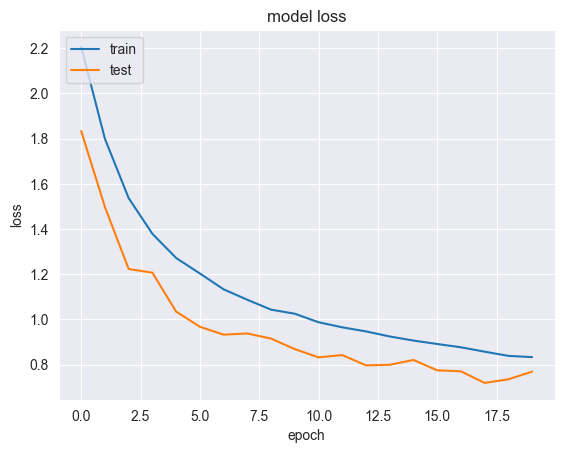

compile_metrics: 71.94%
464/464 - 7s - 16ms/step


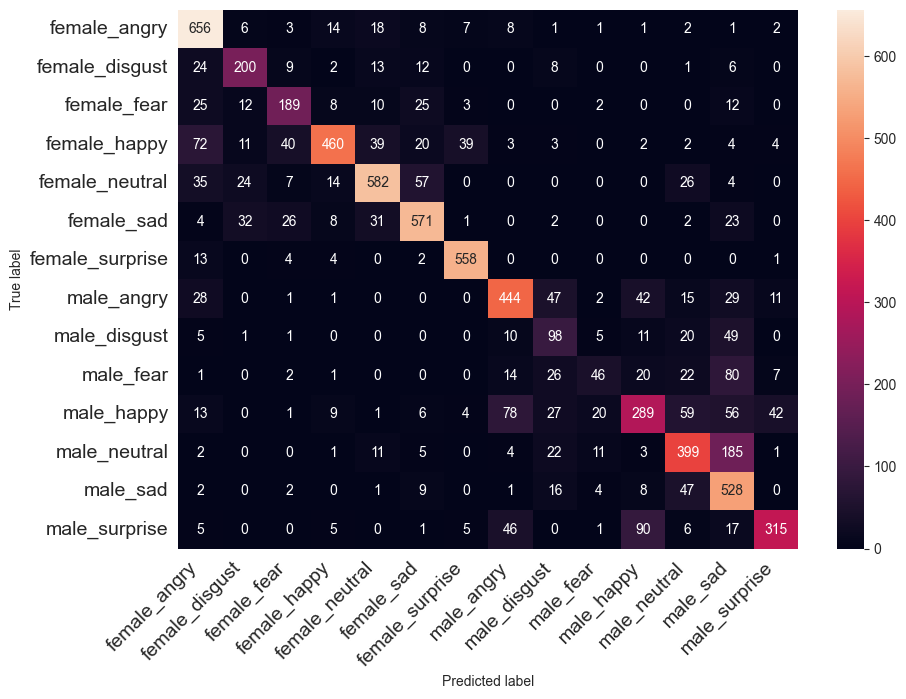

In [45]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

<a id="logmelaug"></a>
## 5. Log-melspectogram with augmentation 
63% accuracy for a log-melspectogram. Slighlty lower than MFCC but very close. Notice however from the logloss plot, the log-melspectogram accuracy potential hasn't quite plateau yet. It's likely that higher number of epochs the accuracy could surpass that of the MFCC, albeit slightly. Eitherways, very interesting! 

So now let's see what happens if we apply the same data augmentation here. 

In [46]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
aug_specgram = prepare_data(ref,  n = n_melspec, aug = 1, mfcc = 0)

100%|██████████| 29662/29662 [12:39<00:00, 39.04it/s] 


In [48]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(aug_specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)  

Epoch 1/20
1391/1391 - 107s - 77ms/step - acc: 0.2468 - loss: 2.1916 - val_acc: 0.3604 - val_loss: 1.8023
Epoch 2/20
1391/1391 - 109s - 78ms/step - acc: 0.3887 - loss: 1.7692 - val_acc: 0.4829 - val_loss: 1.5083
Epoch 3/20
1391/1391 - 109s - 78ms/step - acc: 0.4605 - loss: 1.5474 - val_acc: 0.5374 - val_loss: 1.3365
Epoch 4/20
1391/1391 - 109s - 79ms/step - acc: 0.4976 - loss: 1.4309 - val_acc: 0.5716 - val_loss: 1.2258
Epoch 5/20
1391/1391 - 109s - 78ms/step - acc: 0.5283 - loss: 1.3408 - val_acc: 0.5259 - val_loss: 1.3695
Epoch 6/20
1391/1391 - 109s - 79ms/step - acc: 0.5529 - loss: 1.2689 - val_acc: 0.6344 - val_loss: 1.0667
Epoch 7/20
1391/1391 - 112s - 81ms/step - acc: 0.5743 - loss: 1.2135 - val_acc: 0.6272 - val_loss: 1.0793
Epoch 8/20
1391/1391 - 109s - 78ms/step - acc: 0.5912 - loss: 1.1678 - val_acc: 0.6590 - val_loss: 0.9699
Epoch 9/20
1391/1391 - 109s - 78ms/step - acc: 0.6006 - loss: 1.1372 - val_acc: 0.6791 - val_loss: 0.9423
Epoch 10/20
1391/1391 - 109s - 78ms/step - acc

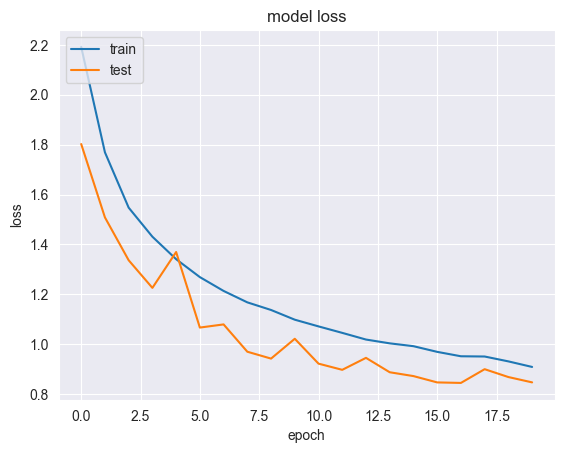

compile_metrics: 70.08%
464/464 - 6s - 13ms/step


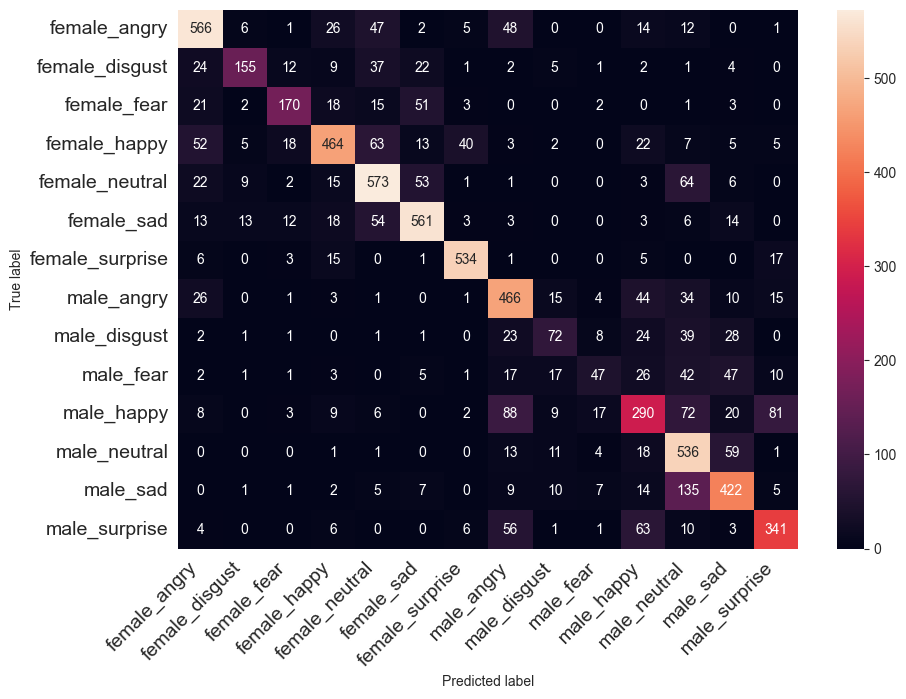

In [50]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

### 63% accuracy as well. Not too different from wihtout doing data augmentation. Slightly dissapointed the data augmentation didn't add much value, but then again I've only implemented just 1 simple version of the augmentation. Can't conclude firmly at this point if augmentation adds any value to it. Also, if augmentation is supposed to prevent overfitting (which is another topic on its own), then seeing a slight drop in accuracy is highly expected and welcomed.

<a id="final"></a>
## Final thoughts
Our advance implementation looks really good! All the 2D CNN models seems to do better than the 1D CNN model aproach that we took in previous parts of this series. In summary our accuracy from various approaches so far: 

- [1D CNN of simple MFCC mean](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model) = __45%__
- [1D CNN of simple MFCC mean with data augmentation](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation) = __48%__
- [2D CNN of entire MFCC without augmentation](#MFCConly) = __64%__
- [2D CNN of entire MFCC with Augmentation](#MFCCaug) = __60%__
- [2D CNN of entire Log-melspectogram without augmentation](#logmelonly) = __63%__
- [2D CNN of entire Log-melspectogram with augmentation ](#logmelaug) = __63%__

A large improvement to the predictive accuracy was made from using the entire MFCC and log-melspectogram information, instead of just a reduced average to fit into a 1D CNN. And because we used a 2D CNN, we could take advantage of the entire information presented through the MFCC and mel-spectogram

Notice that whilst the model isn't perfect at classifying the different emotions, its done pretty well at distinguishing the genders! 

In [ ]:
results.accuracy_results_gender(X_test, y_test, ref.labels.unique(), model)

= They are a few other ideas that I have stashed them for now but if anyone's keen to try it out themselves, then here's what else you can look at: 
- Try a few other datasets (eg. EmoDB)
- Trim white noise (silence)
- Apply the other data augmentation methods
- Transfer learning from popular Image Recognition benchmarks - ResNet50 or XCEPTION or VGG19 for simplicity

We're getting close to the end of the series now so there might be two or three more left, I haven't quite decided on what to show but one of them will involve a concatenation of 2 Deep Learning networks into 1, kind of like an ensemble. it wouldn't be very Kaggle if we didn't do an ensemble right? I don't want to spoil the fun by revealing too much but it could be the next post or the post after. So stay tuned!

In [ ]:

import os
import shutil

# Directory to save models
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Function to save a model
def save_model(model, model_name):
    model_path = os.path.join(save_dir, f'{model_name}.h5')
    model.save(model_path)
    print(f'Model saved to {model_path}')

# Example usage (assuming model names and variables)
save_model(model1, 'model1')
save_model(model2, 'model2')
# Add more models as needed

# List all variables to identify model variables
%whos
